# Библиотеки

In [1]:
!pip install pyspark findspark

In [2]:
import os
import gc
import sys

from typing import (
    Tuple, List, Union,
    Collection, NoReturn,
)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

# PySpark контекст

Как установить PySpark на Windows - [Полный гид](https://www.machinelearningplus.com/pyspark/install-pyspark-on-windows/)

Добавим `PYSPARK_PYTHON` и `PYSPARK_DRIVER_PYTHON` в PATH. [Подробнее](https://stackoverflow.com/questions/48260412/environment-variables-pyspark-python-and-pyspark-driver-python):

In [3]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

Скачаем бинарники `hadoop.dll` и `winutils.exe` последних версий с [гитхаба](https://github.com/kontext-tech/winutils). Оба файла поместим в папку, укажем путь до неё в переменной среды `HADOOP_HOME`. Помимо этого, файл `hadoop.dll` поместим в папку `C:\Windows\System32`. Подробнее [здесь](https://stackoverflow.com/questions/41851066/exception-in-thread-main-java-lang-unsatisfiedlinkerror-org-apache-hadoop-io).

In [4]:
os.environ['HADOOP_HOME'] = 'C:\\hadoop'

In [5]:
import pyspark
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050')\
                  .set('spark.serializer', 'org.apache.spark.serializer.KryoSerializer')\
                  .set('spark.dynamicAllocation.enabled', 'true')\
                  .set('spark.shuffle.service.enabled', 'true') #трекер, чтобы возвращать ресурсы

sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()
display(spark)

In [6]:
print(f"JDK version: {os.popen('java --version').read()}")
print(f"Python version: {sys.version}")
print(f"Spark version: {pyspark.__version__}")
print(f"Hadoop version: {sc._jvm.org.apache.hadoop.util.VersionInfo.getVersion()}")

JDK version: 
Python version: 3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]
Spark version: 3.5.1
Hadoop version: 3.3.4


# Занятие

## Набор данных

Анализируемый датасет взят отсюда: https://www.kaggle.com/shelvigarg/credit-card-buyers

Описание признаков:

* `ID` - уникальный идентификатор для каждой строки
* `Genger` - пол клиента;
* `Age` - возраст клиента (в годах);
* `Region_Code` - код региона клиента;
* `Occupation` - тип профессии клиента;
* `Channel_Code` - код канала приобретения для клиента (в кодировке);
*  `Vintage` - винтаж клиента в месяцах;
*  `Credit_Product` - есть ли у клиента есть какой-либо активный кредитный продукт;
*  `AvgAccountBalance` - средний баланс клиента за последние 12 месяцев;
*  `Is_Active` - активен ли клиент в течение последних 3 месяцев.

Загрузим данные и посмотрим, что там внутри

In [7]:
data = spark.read.csv('credit_card_data.csv', header=True, inferSchema=True)

In [8]:
data.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Region_Code: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Channel_Code: string (nullable = true)
 |-- Vintage: integer (nullable = true)
 |-- Credit_Product: string (nullable = true)
 |-- Avg_Account_Balance: integer (nullable = true)
 |-- Is_Active: string (nullable = true)
 |-- Is_Lead: integer (nullable = true)



In [9]:
data.show()

+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+
|      ID|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|Is_Lead|
+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+
|NNVBBKZB|Female| 73|      RG268|        Other|          X3|     43|            No|            1045696|       No|      0|
|IDD62UNG|Female| 30|      RG277|     Salaried|          X1|     32|            No|             581988|       No|      0|
|HD3DSEMC|Female| 56|      RG268|Self_Employed|          X3|     26|            No|            1484315|      Yes|      0|
|BF3NC7KV|  Male| 34|      RG270|     Salaried|          X1|     19|            No|             470454|       No|      0|
|TEASRWXV|Female| 30|      RG282|     Salaried|          X1|     33|            No|             886787|       No|      0|
|ACUTYTWS|  Male| 56|   

## Пропуски в данных

In [10]:
from pyspark.sql.functions import col, isnan, when, count

In [11]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---+------+---+-----------+----------+------------+-------+--------------+-------------------+---------+-------+
| ID|Gender|Age|Region_Code|Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|Is_Lead|
+---+------+---+-----------+----------+------------+-------+--------------+-------------------+---------+-------+
|  0|     0|  0|          0|         0|           0|      0|         29325|                  0|        0|      0|
+---+------+---+-----------+----------+------------+-------+--------------+-------------------+---------+-------+



Пропуски только в кредитном продукте, логично заметь на тип, что кредита нет

In [12]:
data.select(col('Credit_Product')).groupBy('Credit_Product').count().show()

+--------------+------+
|Credit_Product| count|
+--------------+------+
|          NULL| 29325|
|            No|144357|
|           Yes| 72043|
+--------------+------+



In [13]:
data = data.fillna({'Credit_Product': 'No'})

Проверим

In [14]:
data.select(col('Credit_Product')).groupBy('Credit_Product').count().show()

+--------------+------+
|Credit_Product| count|
+--------------+------+
|            No|173682|
|           Yes| 72043|
+--------------+------+



## Дисбаланс классов

Посмотри на данные с точки зрения дисбаланса классов

In [15]:
data.count()

245725

In [16]:
import pyspark.sql.functions as F

In [17]:
data.select(col('Is_Lead'))\
    .groupBy('Is_Lead')\
    .count()\
    .withColumn('count', F.round(col('count') / data.count(), 2))\
    .show()

+-------+-----+
|Is_Lead|count|
+-------+-----+
|      1| 0.24|
|      0| 0.76|
+-------+-----+



Ладно, достаточно, мы тут сейчас говорим про MLlib, всякие анализы - тема прошлого семинара

## Преобразования данных

### String Indexer

Начнем с простой обработки категориальных переменных

In [18]:
from pyspark.ml.feature import StringIndexer, IndexToString, OneHotEncoder

In [19]:
gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
gender_indexer = gender_indexer.fit(data)
data = gender_indexer.transform(data)

data.show()

+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+
|      ID|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|Is_Lead|GenderIndex|
+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+
|NNVBBKZB|Female| 73|      RG268|        Other|          X3|     43|            No|            1045696|       No|      0|        1.0|
|IDD62UNG|Female| 30|      RG277|     Salaried|          X1|     32|            No|             581988|       No|      0|        1.0|
|HD3DSEMC|Female| 56|      RG268|Self_Employed|          X3|     26|            No|            1484315|      Yes|      0|        1.0|
|BF3NC7KV|  Male| 34|      RG270|     Salaried|          X1|     19|            No|             470454|       No|      0|        0.0|
|TEASRWXV|Female| 30|      RG282|     Salaried|          X1|  

In [20]:
gender_indexer.labels

['Male', 'Female']

Обратная трансформация доступна через метод

In [21]:
converter = IndexToString(inputCol="GenderIndex", outputCol="originalGender")
data = converter.transform(data)
data.show()

+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+--------------+
|      ID|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|Is_Lead|GenderIndex|originalGender|
+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+--------------+
|NNVBBKZB|Female| 73|      RG268|        Other|          X3|     43|            No|            1045696|       No|      0|        1.0|        Female|
|IDD62UNG|Female| 30|      RG277|     Salaried|          X1|     32|            No|             581988|       No|      0|        1.0|        Female|
|HD3DSEMC|Female| 56|      RG268|Self_Employed|          X3|     26|            No|            1484315|      Yes|      0|        1.0|        Female|
|BF3NC7KV|  Male| 34|      RG270|     Salaried|          X1|     19|            No|             470454|   

Давайте аналогично поступим с каналом продаж и типом занятости

In [22]:
occupation_indexer = StringIndexer(inputCol="Occupation", outputCol="OccupationIndex")
occupation_indexer = occupation_indexer.fit(data)
data = occupation_indexer.transform(data)

channel_indexer = StringIndexer(inputCol="Channel_Code", outputCol="ChannelIndex")
channel_indexer = channel_indexer.fit(data)
data = channel_indexer.transform(data)

data.show()

+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+--------------+---------------+------------+
|      ID|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|Is_Lead|GenderIndex|originalGender|OccupationIndex|ChannelIndex|
+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+--------------+---------------+------------+
|NNVBBKZB|Female| 73|      RG268|        Other|          X3|     43|            No|            1045696|       No|      0|        1.0|        Female|            2.0|         1.0|
|IDD62UNG|Female| 30|      RG277|     Salaried|          X1|     32|            No|             581988|       No|      0|        1.0|        Female|            1.0|         0.0|
|HD3DSEMC|Female| 56|      RG268|Self_Employed|          X3|     26|            No|            1484315|      Y

### One-hot encoding

In [23]:
print(f'Occupation len = {len(occupation_indexer.labels)}, Channel_code len = {len(channel_indexer.labels)}')

Occupation len = 4, Channel_code len = 4


Тут по 4 категории, что самое простое, что приходит в голову? Правильно - OHE

In [24]:
ohe_encoder = OneHotEncoder(inputCols=["OccupationIndex", "ChannelIndex"],
                            outputCols=["OccupationVector", "ChannelVec"])

ohe_encoder = ohe_encoder.fit(data)
data = ohe_encoder.transform(data)

data.show()

+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+--------------+---------------+------------+----------------+-------------+
|      ID|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|Is_Lead|GenderIndex|originalGender|OccupationIndex|ChannelIndex|OccupationVector|   ChannelVec|
+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+--------------+---------------+------------+----------------+-------------+
|NNVBBKZB|Female| 73|      RG268|        Other|          X3|     43|            No|            1045696|       No|      0|        1.0|        Female|            2.0|         1.0|   (3,[2],[1.0])|(3,[1],[1.0])|
|IDD62UNG|Female| 30|      RG277|     Salaried|          X1|     32|            No|             581988|       No|      0|        1.0|        Female|            1.0|

In [25]:
ohe_encoder.categorySizes

[4, 4]

Странный формат, не правда ли? Все из-за того, что тут у нас SparseVector

 На 4 категории нужен вектор размерности 3, а дальше храним позицию и 1 там, где нужная категория

In [26]:
data.select(col('OccupationVector')).head()

Row(OccupationVector=SparseVector(3, {2: 1.0}))

Теперь все надо собрать в одну структуру, чтобы можно было анализировать данные и строить модели

In [27]:
from pyspark.ml.feature import VectorAssembler

In [28]:
data.show(5)

+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+--------------+---------------+------------+----------------+-------------+
|      ID|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|Is_Lead|GenderIndex|originalGender|OccupationIndex|ChannelIndex|OccupationVector|   ChannelVec|
+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+--------------+---------------+------------+----------------+-------------+
|NNVBBKZB|Female| 73|      RG268|        Other|          X3|     43|            No|            1045696|       No|      0|        1.0|        Female|            2.0|         1.0|   (3,[2],[1.0])|(3,[1],[1.0])|
|IDD62UNG|Female| 30|      RG277|     Salaried|          X1|     32|            No|             581988|       No|      0|        1.0|        Female|            1.0|

In [29]:
feature_columns = [
    'Age',
    'Vintage',
    'Avg_Account_Balance',
    'GenderIndex',
    'OccupationVector',
    'ChannelVec'                 
]

In [30]:
df_va = VectorAssembler(inputCols = feature_columns, outputCol = 'features')
data = df_va.transform(data)

In [31]:
data.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Region_Code: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Channel_Code: string (nullable = true)
 |-- Vintage: integer (nullable = true)
 |-- Credit_Product: string (nullable = false)
 |-- Avg_Account_Balance: integer (nullable = true)
 |-- Is_Active: string (nullable = true)
 |-- Is_Lead: integer (nullable = true)
 |-- GenderIndex: double (nullable = false)
 |-- originalGender: string (nullable = true)
 |-- OccupationIndex: double (nullable = false)
 |-- ChannelIndex: double (nullable = false)
 |-- OccupationVector: vector (nullable = true)
 |-- ChannelVec: vector (nullable = true)
 |-- features: vector (nullable = true)



In [32]:
data.show()

+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+--------------+---------------+------------+----------------+-------------+--------------------+
|      ID|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|Is_Lead|GenderIndex|originalGender|OccupationIndex|ChannelIndex|OccupationVector|   ChannelVec|            features|
+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+--------------+---------------+------------+----------------+-------------+--------------------+
|NNVBBKZB|Female| 73|      RG268|        Other|          X3|     43|            No|            1045696|       No|      0|        1.0|        Female|            2.0|         1.0|   (3,[2],[1.0])|(3,[1],[1.0])|[73.0,43.0,104569...|
|IDD62UNG|Female| 30|      RG277|     Salaried|          X1|     32|            

В полученном features можно автоматичеки проанализировать все переменные и если у кого-то уникальных значений меньше заданного вами порога, то они автоматически переведутся в индексы при помощи pyspark.ml.feature import VectorIndexer

## Статистика

В ml pyspark есть некоторые статистические методы, которые можно использовать для анализа

### Корреляция

In [33]:
from pyspark.ml.stat import Correlation

In [34]:
corr = Correlation.corr(data, 'features', method='pearson').collect()[0][0]

In [35]:
corr

DenseMatrix(10, 10, [1.0, 0.6312, 0.1452, -0.1521, 0.1527, -0.5632, 0.3948, -0.6646, ..., 0.0102, -0.116, 0.2933, -0.3238, 0.0005, -0.5272, -0.3843, 1.0], False)

In [36]:
corr.toArray()

array([[ 1.00000000e+00,  6.31242411e-01,  1.45232189e-01,
        -1.52075940e-01,  1.52651808e-01, -5.63226982e-01,
         3.94834177e-01, -6.64600051e-01,  4.56338440e-01,
         2.73153253e-01],
       [ 6.31242411e-01,  1.00000000e+00,  1.67433481e-01,
        -1.46379743e-01,  2.21023818e-01, -4.10109383e-01,
         1.55662661e-01, -5.71828453e-01,  5.38828562e-01,
         1.44931244e-01],
       [ 1.45232189e-01,  1.67433481e-01,  1.00000000e+00,
        -2.24772031e-02,  3.46714040e-03, -7.16906860e-02,
         6.03874569e-02, -9.81785292e-02,  1.06905544e-01,
         1.01634033e-02],
       [-1.52075940e-01, -1.46379743e-01, -2.24772031e-02,
         1.00000000e+00, -8.58626857e-02,  1.22439249e-01,
        -2.58175123e-02,  1.84372479e-01, -8.07817702e-02,
        -1.16018433e-01],
       [ 1.52651808e-01,  2.21023818e-01,  3.46714040e-03,
        -8.58626857e-02,  1.00000000e+00, -5.37283514e-01,
        -5.27660791e-01, -4.34990948e-01,  1.63662837e-01,
         2.

Можно вычислить корреляцию спирмена

In [37]:
corr = Correlation.corr(data, 'features', method='spearman').collect()[0][0]
corr.toArray()

array([[ 1.00000000e+00,  6.52477119e-01,  1.78395617e-01,
        -1.66276503e-01,  2.50479037e-01, -5.94192974e-01,
         3.16280765e-01, -7.14324073e-01,  4.68523607e-01,
         3.11874367e-01],
       [ 6.52477119e-01,  1.00000000e+00,  1.98039737e-01,
        -1.37241231e-01,  2.26617372e-01, -4.03612329e-01,
         1.44248315e-01, -5.43361590e-01,  4.88850315e-01,
         1.86509197e-01],
       [ 1.78395617e-01,  1.98039737e-01,  1.00000000e+00,
        -3.35726184e-02,  1.74003362e-02, -9.65169583e-02,
         6.80005979e-02, -1.34528255e-01,  1.34941462e-01,
         2.41122172e-02],
       [-1.66276503e-01, -1.37241231e-01, -3.35726184e-02,
         1.00000000e+00, -8.58626857e-02,  1.22439249e-01,
        -2.58175123e-02,  1.84372479e-01, -8.07817702e-02,
        -1.16018433e-01],
       [ 2.50479037e-01,  2.26617372e-01,  1.74003362e-02,
        -8.58626857e-02,  1.00000000e+00, -5.37283514e-01,
        -5.27660791e-01, -4.34990948e-01,  1.63662837e-01,
         2.

### Хи-квадрат

Можно использовать хи-квадрат тест для оценки независимости каждой переменной в features относительно целевого признака, но этот тест для категориальных переменных, поэтому для примера на одной фиче

In [38]:
from pyspark.ml.stat import ChiSquareTest, KolmogorovSmirnovTest, Summarizer

In [39]:
r = ChiSquareTest.test(data, "OccupationVector", "Is_Lead")

In [40]:
r.show()

+--------------------+----------------+--------------------+
|             pValues|degreesOfFreedom|          statistics|
+--------------------+----------------+--------------------+
|[0.0,0.0,1.161583...|       [1, 1, 1]|[1420.86324574575...|
+--------------------+----------------+--------------------+



### KS-тест

In [41]:
data.select(
    F.mean(col('Age')).alias('mean_Age'),
    F.stddev(col('Age')).alias('std_Age')
).collect()

[Row(mean_Age=43.85630684708516, std_Age=14.828671804648)]

In [42]:
ks = KolmogorovSmirnovTest.test(data, 'Age', 'norm', 44, 15).first()

In [43]:
ks

Row(pValue=2.045950076023928e-10, statistic=0.12561207843265512)

### Общие статистики

Еще можно посчитать разные статистики

In [44]:
summarizer = Summarizer.metrics("mean", "count")
data.select(summarizer.summary(data.features)).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|aggregate_metrics(features, 1.0)                                                                                                                                                                         |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{[43.8563068470851,46.95914131651203,1128403.1010194335,0.4538732322718486,0.4105646556109472,0.29300640960423235,0.2855753382846678,0.42208973445925324,0.2796296673110184,0.27561705158205313], 245725}|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Работа с фичами

### Квантизация

In [45]:
from pyspark.ml.feature import QuantileDiscretizer

Обучаем

In [46]:
discretizer = QuantileDiscretizer(numBuckets=5, inputCol="Age", outputCol="Age_quant")
discretizer = discretizer.fit(data)

In [47]:
data = discretizer.transform(data)

In [48]:
data.select('Age', 'Age_quant')\
    .groupby('Age_quant').agg(
        F.min('Age').alias('min_age'),
        F.max('Age').alias('max_age'),
        F.count('Age').alias('count')
    )\
    .orderBy('Age_quant')\
    .show(5)

+---------+-------+-------+-----+
|Age_quant|min_age|max_age|count|
+---------+-------+-------+-----+
|      0.0|     23|     28|43790|
|      1.0|     29|     35|52017|
|      2.0|     36|     46|46007|
|      3.0|     47|     55|50808|
|      4.0|     56|     85|53103|
+---------+-------+-------+-----+



### Заполнение пропусков через Imputer

Заполнить пропуски можно через Imputer

Заполнять пропуски умеет только для числовых переменных, поэтому попробуем на игрушечном примере



In [49]:
from pyspark.ml.feature import Imputer

In [50]:
df = spark.createDataFrame([
    (1.0, float("nan")),
    (2.0, float("nan")),
    (float("nan"), 3.0),
    (4.0, 4.0),
    (5.0, 5.0)
], ["a", "b"])

#стратегия может быть 'mean', 'median', 'mode'
#через setMissingValue(0.0) можно сказать, что пропуски - это 0
imputer = Imputer(inputCols=["a", "b"], outputCols=["out_a", "out_b"], strategy='mean')
imputer = imputer.fit(df)
imputer.transform(df).show()

+---+---+-----+-----+
|  a|  b|out_a|out_b|
+---+---+-----+-----+
|1.0|NaN|  1.0|  4.0|
|2.0|NaN|  2.0|  4.0|
|NaN|3.0|  3.0|  3.0|
|4.0|4.0|  4.0|  4.0|
|5.0|5.0|  5.0|  5.0|
+---+---+-----+-----+



## Pipeline

Как и в scikit-learn можно создавать пайплайны обработки данных

Мы много делали преобразований, давайте соберем все в 1 пайплайн

In [51]:
from pyspark.ml import Pipeline

In [52]:
# string в индесы
gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
occupation_indexer = StringIndexer(inputCol="Occupation", outputCol="OccupationIndex")
channel_indexer = StringIndexer(inputCol="Channel_Code", outputCol="ChannelIndex")

# OHE
ohe_encoder = OneHotEncoder(inputCols=["OccupationIndex", "ChannelIndex"],
                        outputCols=["OccupationVector", "ChannelVec"])

# квантизация
discretizer = QuantileDiscretizer(numBuckets=5, inputCol="Age", outputCol="Age_quant")

# собираем все в вектор
feature_columns = [
    'Age',
    'Vintage',
    'Avg_Account_Balance',
    'GenderIndex',
    'OccupationVector',
    'ChannelVec',
    'Age_quant'                 
]

vector_assembler = VectorAssembler(inputCols = feature_columns, outputCol = 'features')

собираем все в пайплайн

In [53]:
pipeline = Pipeline(stages=[
    gender_indexer,
    occupation_indexer,
    channel_indexer,
    ohe_encoder,
    discretizer,
    vector_assembler,
])

Давайте заново загрузим данные и сделаем трансформацию

---



In [54]:
data = spark.read.csv('credit_card_data.csv', header=True, inferSchema=True)
data = data.fillna({'Credit_Product': 'No'})
pipeline = pipeline.fit(data)

In [55]:
transformed_data = pipeline.transform(data)

In [56]:
transformed_data.show()

+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+---------------+------------+----------------+-------------+---------+--------------------+
|      ID|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|Is_Lead|GenderIndex|OccupationIndex|ChannelIndex|OccupationVector|   ChannelVec|Age_quant|            features|
+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+---------------+------------+----------------+-------------+---------+--------------------+
|NNVBBKZB|Female| 73|      RG268|        Other|          X3|     43|            No|            1045696|       No|      0|        1.0|            2.0|         1.0|   (3,[2],[1.0])|(3,[1],[1.0])|      4.0|[73.0,43.0,104569...|
|IDD62UNG|Female| 30|      RG277|     Salaried|          X1|     32|            No|             5819

In [57]:
transformed_data.select('Is_Lead', 'features').show(5)

+-------+--------------------+
|Is_Lead|            features|
+-------+--------------------+
|      0|[73.0,43.0,104569...|
|      0|[30.0,32.0,581988...|
|      0|[56.0,26.0,148431...|
|      0|(11,[0,1,2,5,7,10...|
|      0|[30.0,33.0,886787...|
+-------+--------------------+
only showing top 5 rows



## Модельки

Пора нам уже что-то обучить, начнем с логрега

In [58]:
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel

In [59]:
log_reg = LogisticRegression(featuresCol='features', labelCol='Is_Lead', predictionCol='prediction',
                             maxIter=100, probabilityCol='proba')

log_reg = log_reg.fit(transformed_data)

Сохраним

In [60]:
log_reg.write().overwrite().save('logreg_model')

Загрузка

In [61]:
log_reg2 = LogisticRegressionModel.load('logreg_model')

Коэффициенты и метрики

In [62]:
print("Coefficients: " + str(log_reg.coefficients))
print("Intercept: " + str(log_reg.intercept))

Coefficients: [-0.01671304480797569,0.009916392983818797,9.918267490175646e-09,-0.05296577197066117,-1.5152849582703456,-0.5266676981710371,-1.5009517711182658,-1.5679772035542516,-0.14595364437205402,-0.057606644519336815,0.34189553941575607]
Intercept: 0.09853176624434656


In [63]:
print("Coefficients: " + str(log_reg2.coefficients))
print("Intercept: " + str(log_reg2.intercept))

Coefficients: [-0.01671304480797569,0.009916392983818797,9.918267490175646e-09,-0.05296577197066117,-1.5152849582703456,-0.5266676981710371,-1.5009517711182658,-1.5679772035542516,-0.14595364437205402,-0.057606644519336815,0.34189553941575607]
Intercept: 0.09853176624434656


In [64]:
print(f'ROC_AUC = {log_reg.summary.areaUnderROC}')

ROC_AUC = 0.7291594391490084


In [65]:
log_reg.summary.recallByLabel

[0.9880226422744709, 0.10472138347515783]

In [66]:
log_reg.params

[Param(parent='LogisticRegression_ad99fae63c7b', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'),
 Param(parent='LogisticRegression_ad99fae63c7b', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'),
 Param(parent='LogisticRegression_ad99fae63c7b', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'),
 Param(parent='LogisticRegression_ad99fae63c7b', name='featuresCol', doc='features column name.'),
 Param(parent='LogisticRegression_ad99fae63c7b', name='fitIntercept', doc='whether to fit an intercept term.'),
 Param(parent='LogisticRegression_ad99fae63c7b', name='labelCol', doc='label column name.'),
 Param(parent='LogisticRegression_ad99fae63c7b', name='lowerBoundsOnCoefficients', doc='The lower bounds on coefficients if fitting under bound cons

In [67]:
log_reg.transform(transformed_data.select('Is_Lead', 'features')).show()

+-------+--------------------+--------------------+--------------------+----------+
|Is_Lead|            features|       rawPrediction|               proba|prediction|
+-------+--------------------+--------------------+--------------------+----------+
|      0|[73.0,43.0,104569...|[1.01703314359022...|[0.73439428907030...|       0.0|
|      0|[30.0,32.0,581988...|[1.88547782413284...|[0.86823905458578...|       0.0|
|      0|[56.0,26.0,148431...|[0.91147290916335...|[0.71330147094131...|       0.0|
|      0|(11,[0,1,2,5,7,10...|[2.02938356422997...|[0.88384780907757...|       0.0|
|      0|[30.0,33.0,886787...|[1.87253835313628...|[0.86675171295995...|       0.0|
|      0|(11,[0,1,2,4,7,10...|[2.23035701748940...|[0.90294265153494...|       0.0|
|      1|(11,[0,1,2,6,8,10...|[1.00819128083082...|[0.73266603083228...|       0.0|
|      0|[48.0,13.0,444724...|[1.25888814052333...|[0.77883464798430...|       0.0|
|      0|[40.0,38.0,127428...|[1.12259469904794...|[0.75446968923716...|    

## Подбор параметров

Тут нет всяких hyperopt, optuna... есть стандартная кросс-валидация и поиск по сетке

In [68]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

Для этого соберем все в пайплайн. Можно было "вложить" старый пайплайн в новый, но соберем все с самого начала

In [69]:
# string в индесы
gender_indexer     = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
occupation_indexer = StringIndexer(inputCol="Occupation", outputCol="OccupationIndex")
channel_indexer    = StringIndexer(inputCol="Channel_Code", outputCol="ChannelIndex")

# OHE
ohe_encoder = OneHotEncoder(inputCols=["OccupationIndex", "ChannelIndex"],
                            outputCols=["OccupationVector", "ChannelVec"])

# квантизация
discretizer = QuantileDiscretizer(numBuckets=5, inputCol="Age", outputCol="Age_quant")

# собираем все в вектор
feature_columns = [
    'Age',
    'Vintage',
    'Avg_Account_Balance',
    'GenderIndex',
    'OccupationVector',
    'ChannelVec',
    'Age_quant'                 
]

vector_assembler = VectorAssembler(inputCols = feature_columns, outputCol = 'features')

log_reg = LogisticRegression(featuresCol='features', labelCol='Is_Lead', predictionCol='prediction',
                             maxIter=100, probabilityCol='proba')

In [70]:
pipeline = Pipeline(stages=[
    gender_indexer,
    occupation_indexer,
    channel_indexer,
    ohe_encoder,
    discretizer,
    vector_assembler,
    log_reg
])

Сетка параметров

In [71]:
paramGrid = ParamGridBuilder() \
    .addGrid(discretizer.numBuckets, [5, 10]) \
    .addGrid(log_reg.maxIter, [10, 20]) \
    .build()

Разобьем данные на train, test

In [72]:
train, test = data.randomSplit([0.7, 0.3], seed=7)

Описываем стратегию кросс-валидации

In [73]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',
                                                                  labelCol='Is_Lead', metricName='areaUnderROC'),
                          numFolds=2,
                          parallelism=2)

Поняем сетку. Знаю, перебор по сетке прошлый век, но что поделать)

In [74]:
cvModel = crossval.fit(train)

In [75]:
cvModel.avgMetrics

[0.729007027027049, 0.729450232190062, 0.7286465840208005, 0.7292789619476565]

Параметры

In [76]:
import numpy as np
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='QuantileDiscretizer_113aa8ba14ec', name='numBuckets', doc='Maximum number of buckets (quantiles, or categories) into which data points are grouped. Must be >= 2.'): 5, Param(parent='LogisticRegression_6dcde0d3dc23', name='maxIter', doc='max number of iterations (>= 0).'): 20}


Сделаем предикт

In [77]:
test_pred = cvModel.transform(test)

In [78]:
test_pred.show()

+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+---------------+------------+----------------+-------------+---------+--------------------+--------------------+--------------------+----------+
|      ID|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|Is_Lead|GenderIndex|OccupationIndex|ChannelIndex|OccupationVector|   ChannelVec|Age_quant|            features|       rawPrediction|               proba|prediction|
+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+-----------+---------------+------------+----------------+-------------+---------+--------------------+--------------------+--------------------+----------+
|225QHWFK|  Male| 35|      RG251|     Salaried|          X3|     32|            No|            1118187|      Yes|      1|        0.0|            1.0|         1.0|   (

Проверим модель

In [79]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',
                                          labelCol='Is_Lead', metricName='areaUnderROC')

In [80]:
evaluator.evaluate(test_pred)

0.727995947261331

In [81]:
evaluator.evaluate(cvModel.transform(train))

0.7295666866554003

Сохраним пайплайн

In [82]:
cvModel.write().overwrite().save('model')

вместо кросс-валидации можно взять TrainValidationSplit для подбора параметров, это train_test_split

# Домашнее задание

Кто проходил курс GPU прекрасно знают датасет.
Данные находятся в файле Train_Set_90621.csv
Amount Defaulted - эту переменную нужно удалить=)

Что ожидается? - творчество)

1) Начните с анализа баланса классов, пропусков, статистик при помощи DataFrame API
2) Посмотрите статистики, заполните пропуски при помощи уже MLlib
3) Соберите пайплайн, похожий на наш, где будет обработка данных, обучение моделей и все при помощи Spark
4) Разбейте данные на train/test + реализуйте подбор параметров одним из способов спарка
5) Cохраните пайплайн на диск
6) Проверьте качество модели на отложенной test выборке

## Набор данных

In [83]:
data = spark.read.csv('Train_Set_90621.csv', header=True, inferSchema=True)\
            .drop('Amount Defaulted')

In [84]:
def shape(df: pyspark.sql.DataFrame) -> Tuple[int, int]:
    return (df.count(), len(df.columns))

In [85]:
def print_shape(df: pyspark.sql.DataFrame) -> NoReturn:
    print("{:_} rows x {:_} cols".format(*shape(data)))

In [86]:
print_shape(data)

195_118 rows x 28 cols


In [87]:
def head(df: pyspark.sql.DataFrame, n_take: int = 5) -> pd.DataFrame:
    return spark.createDataFrame(df.take(n_take), schema=df.schema).toPandas()

In [88]:
display(head(data).style)

,Application ID,Bank Masked,Bank Type,Approved_Timestamp,Name Masked,Business Owner State,Business_Industry_Type_Code,Approved_Year,New Business,Term,BankState,Interest Rate,Employees,Gross Disbursed Amount,Term_years,Jobs Retained,Male to Female Employees Ratio,Expected Company Income,Funds available with company,Gross_Apprv_Amount,Company Branch Code,City or Rural,Jobs Generated,Carry-forward Credit,Documents Provided,Balance Left,Final_Appved_Amount,Default_Status
0,1020200001,Bank_Name_316,Private,12-10-2005,Business_Name_10007,Uttar Pradesh,525161,2005,1,219,Uttar Pradesh,3,42,18550000,18,18,4,3500000,780590,18550000,25650,1,3,N,N,0,13912500,0
1,1020200002,Bank_Name_1062,Govt,21-11-2006,Business_Name_130906,Uttar Pradesh,1231,2006,1,71,Uttar Pradesh,5,20,3045000,6,10,16,1666667,1835637,2450000,0,1,0,Y,N,0,1225000,1
2,1020200003,Bank_Name_39,Private,28-11-2007,Business_Name_105953,Uttar Pradesh,322442,2007,2,84,Maharashtra,8,16,1750000,7,10,8,1333333,2373333,1750000,0,2,2,Y,N,0,1487500,0
3,1020200004,Bank_Name_3,Govt,18-04-2009,Business_Name_103197,Kerala,1231,2009,1,300,Delhi,8,4,38850000,25,2,6,333333,2346786,38850000,1,1,0,N,N,0,29137500,0
4,1020200005,Bank_Name_126,Govt,23-11-2002,Business_Name_118932,Delhi,1231,2002,2,153,Maharashtra,11,4,2800000,13,0,8,333333,2382995,2800000,1,2,0,N,Y,0,2380000,0


In [89]:
data.printSchema()

root
 |-- Application ID: integer (nullable = true)
 |-- Bank Masked: string (nullable = true)
 |-- Bank Type: string (nullable = true)
 |-- Approved_Timestamp: string (nullable = true)
 |-- Name Masked: string (nullable = true)
 |-- Business Owner State: string (nullable = true)
 |-- Business_Industry_Type_Code: integer (nullable = true)
 |-- Approved_Year: integer (nullable = true)
 |-- New Business: integer (nullable = true)
 |-- Term: integer (nullable = true)
 |-- BankState: string (nullable = true)
 |-- Interest Rate: integer (nullable = true)
 |-- Employees: integer (nullable = true)
 |-- Gross Disbursed Amount: integer (nullable = true)
 |-- Term_years: integer (nullable = true)
 |-- Jobs Retained: integer (nullable = true)
 |-- Male to Female Employees Ratio: integer (nullable = true)
 |-- Expected Company Income: long (nullable = true)
 |-- Funds available with company: integer (nullable = true)
 |-- Gross_Apprv_Amount: integer (nullable = true)
 |-- Company Branch Code: inte

In [90]:
TARGET_COLUMN = 'Default_Status'
ID_COLUMN     = 'Application ID'
DATE_COLUMN   = 'Approved_Timestamp'

In [91]:
def check_unique_key(df: pyspark.sql.DataFrame, key: Union[str, List[str]]) -> NoReturn:
    df.groupby(key)\
      .count()\
      .orderBy(F.col('count').desc())\
      .show(3)

In [92]:
check_unique_key(data, ID_COLUMN)

+--------------+-----+
|Application ID|count|
+--------------+-----+
|    1020200084|    1|
|    1020200234|    1|
|    1020200292|    1|
+--------------+-----+
only showing top 3 rows



## Предобработка данных

### Категориальные переменные

Выведем общую информацию по всем колонкам:

In [93]:
def cat_info(df: pyspark.sql.DataFrame): 
    return df.fillna('None')\
             .select(*[F.collect_set(c).alias(c) for c in data.columns])\
             .toPandas()\
             .rename({0: 'categories'})\
             .transpose()\
             .assign(distinct_counts=lambda x: x['categories'].apply(len))\
             .assign(dtype=[c[1] for c in data.dtypes])\
             .sort_values('distinct_counts')

In [94]:
cat_info(data)

,categories,distinct_counts,dtype
Default_Status,"[0, 1]",2,int
Balance Left,"[0, 42000, 1750000]",3,int
Bank Type,"[Private, None, Govt]",3,string
Carry-forward Credit,"[N, None, Y]",3,string
Documents Provided,"[N, None, Y]",3,string
City or Rural,"[0, 1, 2]",3,int
New Business,"[0, 1, 2]",3,int
Interest Rate,"[12, 9, 5, 2, 6, 3, 10, 7, 4, 11, 8]",11,int
Business Owner State,"[Punjab, Uttar Pradesh, Haryana, Orissa, Tamil...",11,string
BankState,"[Punjab, Goa, Uttar Pradesh, Haryana, Orissa, ...",13,string


Подозрительные колонки:

In [95]:
data.fillna('None').groupby('Balance Left').count().show()

+------------+------+
|Balance Left| count|
+------------+------+
|           0|195116|
|     1750000|     1|
|       42000|     1|
+------------+------+



Создадим общий список категориальных фичей:

In [96]:
CAT_FEATURES = [
    'Bank Type',
    'Documents Provided',
    'Carry-forward Credit',
    'City or Rural',
    'New Business',
    'Business Owner State',
    'BankState',
    'Company Branch Code',
    'Bank Masked',
    'Name Masked',
]

Выберем из него строковые переменные:

In [97]:
string_cat_features = [
    c for c in CAT_FEATURES
    if c in set(s[0] for s in data.dtypes if 'string' in s[1])
]

Применим `StringIndexer` к каждой строковой переменной:

In [98]:
def apply_string_indexer(data, cols):
    """Применяет StringIndexer к cols"""
    indexers = {}
    for col in tqdm(cols):
        indexer = StringIndexer(inputCol=col, outputCol=f'{col}_idx', handleInvalid="keep").fit(data)
        data = indexer.transform(data)
        
        # Есть нюансы со строчкой кода ниже.
        # StringIndexer с параметром "keep" выделяет пропуск в отдельную категорию.
        # Хотелось, чтобы он оставил пропуск, чтобы заполнить его уже Imputer'ом с параметром 'mode'.
        # Если раскомментить строку ниже, то так и работает, однако в Pipeline нельзя использовать withColumn()

        # data = data.withColumn(f'{col}_idx', F.when(data[col].isNull(), None).otherwise(data[f'{col}_idx']))
        
        indexers[col] = indexer
    return data, indexers

In [99]:
data, indexers = apply_string_indexer(data, string_cat_features)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.00it/s]


Обновим список категориальных фичей:

In [100]:
CAT_FEATURES = list(set(CAT_FEATURES).union(set([f"{col}_idx" for col in string_cat_features])))
display(CAT_FEATURES)

['Bank Type',
 'Carry-forward Credit_idx',
 'Business Owner State',
 'Documents Provided_idx',
 'Bank Masked_idx',
 'New Business',
 'BankState',
 'Company Branch Code',
 'City or Rural',
 'Bank Masked',
 'Business Owner State_idx',
 'BankState_idx',
 'Documents Provided',
 'Name Masked_idx',
 'Carry-forward Credit',
 'Name Masked',
 'Bank Type_idx']

Заведем список используемых для обучения фичей:

In [101]:
FEATURES = list(set(CAT_FEATURES) - set(string_cat_features))
display(FEATURES)

['Carry-forward Credit_idx',
 'Documents Provided_idx',
 'Bank Masked_idx',
 'New Business',
 'Company Branch Code',
 'City or Rural',
 'BankState_idx',
 'Name Masked_idx',
 'Business Owner State_idx',
 'Bank Type_idx']

### Числовые переменные

In [102]:
INT_COLUMNS = list(set(data.columns) - set(CAT_FEATURES + [ID_COLUMN, DATE_COLUMN, TARGET_COLUMN]))
display(INT_COLUMNS)

['Balance Left',
 'Approved_Year',
 'Male to Female Employees Ratio',
 'Gross Disbursed Amount',
 'Jobs Generated',
 'Term',
 'Interest Rate',
 'Business_Industry_Type_Code',
 'Jobs Retained',
 'Expected Company Income',
 'Final_Appved_Amount',
 'Term_years',
 'Gross_Apprv_Amount',
 'Employees',
 'Funds available with company']

Добавим их в список используемых фичей:

In [103]:
FEATURES += INT_COLUMNS
display(FEATURES)

['Carry-forward Credit_idx',
 'Documents Provided_idx',
 'Bank Masked_idx',
 'New Business',
 'Company Branch Code',
 'City or Rural',
 'BankState_idx',
 'Name Masked_idx',
 'Business Owner State_idx',
 'Bank Type_idx',
 'Balance Left',
 'Approved_Year',
 'Male to Female Employees Ratio',
 'Gross Disbursed Amount',
 'Jobs Generated',
 'Term',
 'Interest Rate',
 'Business_Industry_Type_Code',
 'Jobs Retained',
 'Expected Company Income',
 'Final_Appved_Amount',
 'Term_years',
 'Gross_Apprv_Amount',
 'Employees',
 'Funds available with company']

Уберем ненужные колонки с датафрейма:

In [104]:
data = data.select([ID_COLUMN, DATE_COLUMN, TARGET_COLUMN] + FEATURES)

### Заполнение пропусков

In [105]:
def count_nans(df: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
    return df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])

In [106]:
def nan_info(df: pyspark.sql.DataFrame) -> pd.DataFrame:
    nans = count_nans(data)
    return nans.toPandas()\
               .rename({0: 'count_nans'})\
               .transpose()\
               .assign(percent_nans=lambda x: x / data.count() * 100)\
               .assign(dtype=[c[1] for c in data.dtypes])\
               .query('count_nans != 0')

In [107]:
nan_info(data)

,count_nans,percent_nans,dtype
Approved_Timestamp,426,0.218329,string
New Business,36,0.018450,int
Expected Company Income,3,0.001538,bigint


In [108]:
imputer = Imputer(inputCols=FEATURES, outputCols=FEATURES, strategy='mode')
imputer = imputer.fit(data)
data    = imputer.transform(data)

In [109]:
nan_info(data)

,count_nans,percent_nans,dtype
Approved_Timestamp,426,0.218329,string


### Создание вектора фичей

In [110]:
data = VectorAssembler(inputCols = FEATURES, outputCol = 'features').transform(data)

In [111]:
data.select(ID_COLUMN, DATE_COLUMN, TARGET_COLUMN, 'features').show()

+--------------+------------------+--------------+--------------------+
|Application ID|Approved_Timestamp|Default_Status|            features|
+--------------+------------------+--------------+--------------------+
|    1020200001|        12-10-2005|             0|[0.0,0.0,1260.0,1...|
|    1020200002|        21-11-2006|             1|[1.0,0.0,564.0,1....|
|    1020200003|        28-11-2007|             0|[1.0,0.0,21.0,2.0...|
|    1020200004|        18-04-2009|             0|[0.0,0.0,1.0,1.0,...|
|    1020200005|        23-11-2002|             0|[0.0,1.0,33.0,2.0...|
|    1020200006|        23-12-2009|             0|[0.0,1.0,1419.0,1...|
|    1020200007|        04-10-2009|             0|[0.0,1.0,10.0,2.0...|
|    1020200008|        03-03-2006|             0|[0.0,0.0,10.0,1.0...|
|    1020200009|        03-08-2017|             0|[0.0,1.0,7158.0,2...|
|    1020200010|        20-06-2017|             0|[0.0,0.0,5.0,1.0,...|
|    1020200011|        05-09-2010|             1|[0.0,0.0,186.0

In [112]:
data.printSchema()

root
 |-- Application ID: integer (nullable = true)
 |-- Approved_Timestamp: string (nullable = true)
 |-- Default_Status: integer (nullable = true)
 |-- Carry-forward Credit_idx: double (nullable = false)
 |-- Documents Provided_idx: double (nullable = false)
 |-- Bank Masked_idx: double (nullable = false)
 |-- New Business: integer (nullable = true)
 |-- Company Branch Code: integer (nullable = true)
 |-- City or Rural: integer (nullable = true)
 |-- BankState_idx: double (nullable = false)
 |-- Name Masked_idx: double (nullable = false)
 |-- Business Owner State_idx: double (nullable = false)
 |-- Bank Type_idx: double (nullable = false)
 |-- Balance Left: integer (nullable = true)
 |-- Approved_Year: integer (nullable = true)
 |-- Male to Female Employees Ratio: integer (nullable = true)
 |-- Gross Disbursed Amount: integer (nullable = true)
 |-- Jobs Generated: integer (nullable = true)
 |-- Term: integer (nullable = true)
 |-- Interest Rate: integer (nullable = true)
 |-- Busines

## Статистики

### Баланс классов

In [113]:
data.groupby(TARGET_COLUMN)\
    .count()\
    .withColumn('percent', F.col('count') / data.count() * 100)\
    .show()

+--------------+------+------------------+
|Default_Status| count|           percent|
+--------------+------+------------------+
|             1| 35238|18.059840711774413|
|             0|159880| 81.94015928822559|
+--------------+------+------------------+



### Корреляция

In [114]:
corr = Correlation.corr(data, 'features', method='pearson').collect()[0][0]
display(corr)

DenseMatrix(25, 25, [1.0, -0.1713, -0.0025, -0.0794, -0.0889, 0.2618, -0.0054, -0.0001, ..., -0.0018, -0.0016, -0.0307, 0.0001, 0.0025, -0.0007, 0.0088, 1.0], False)

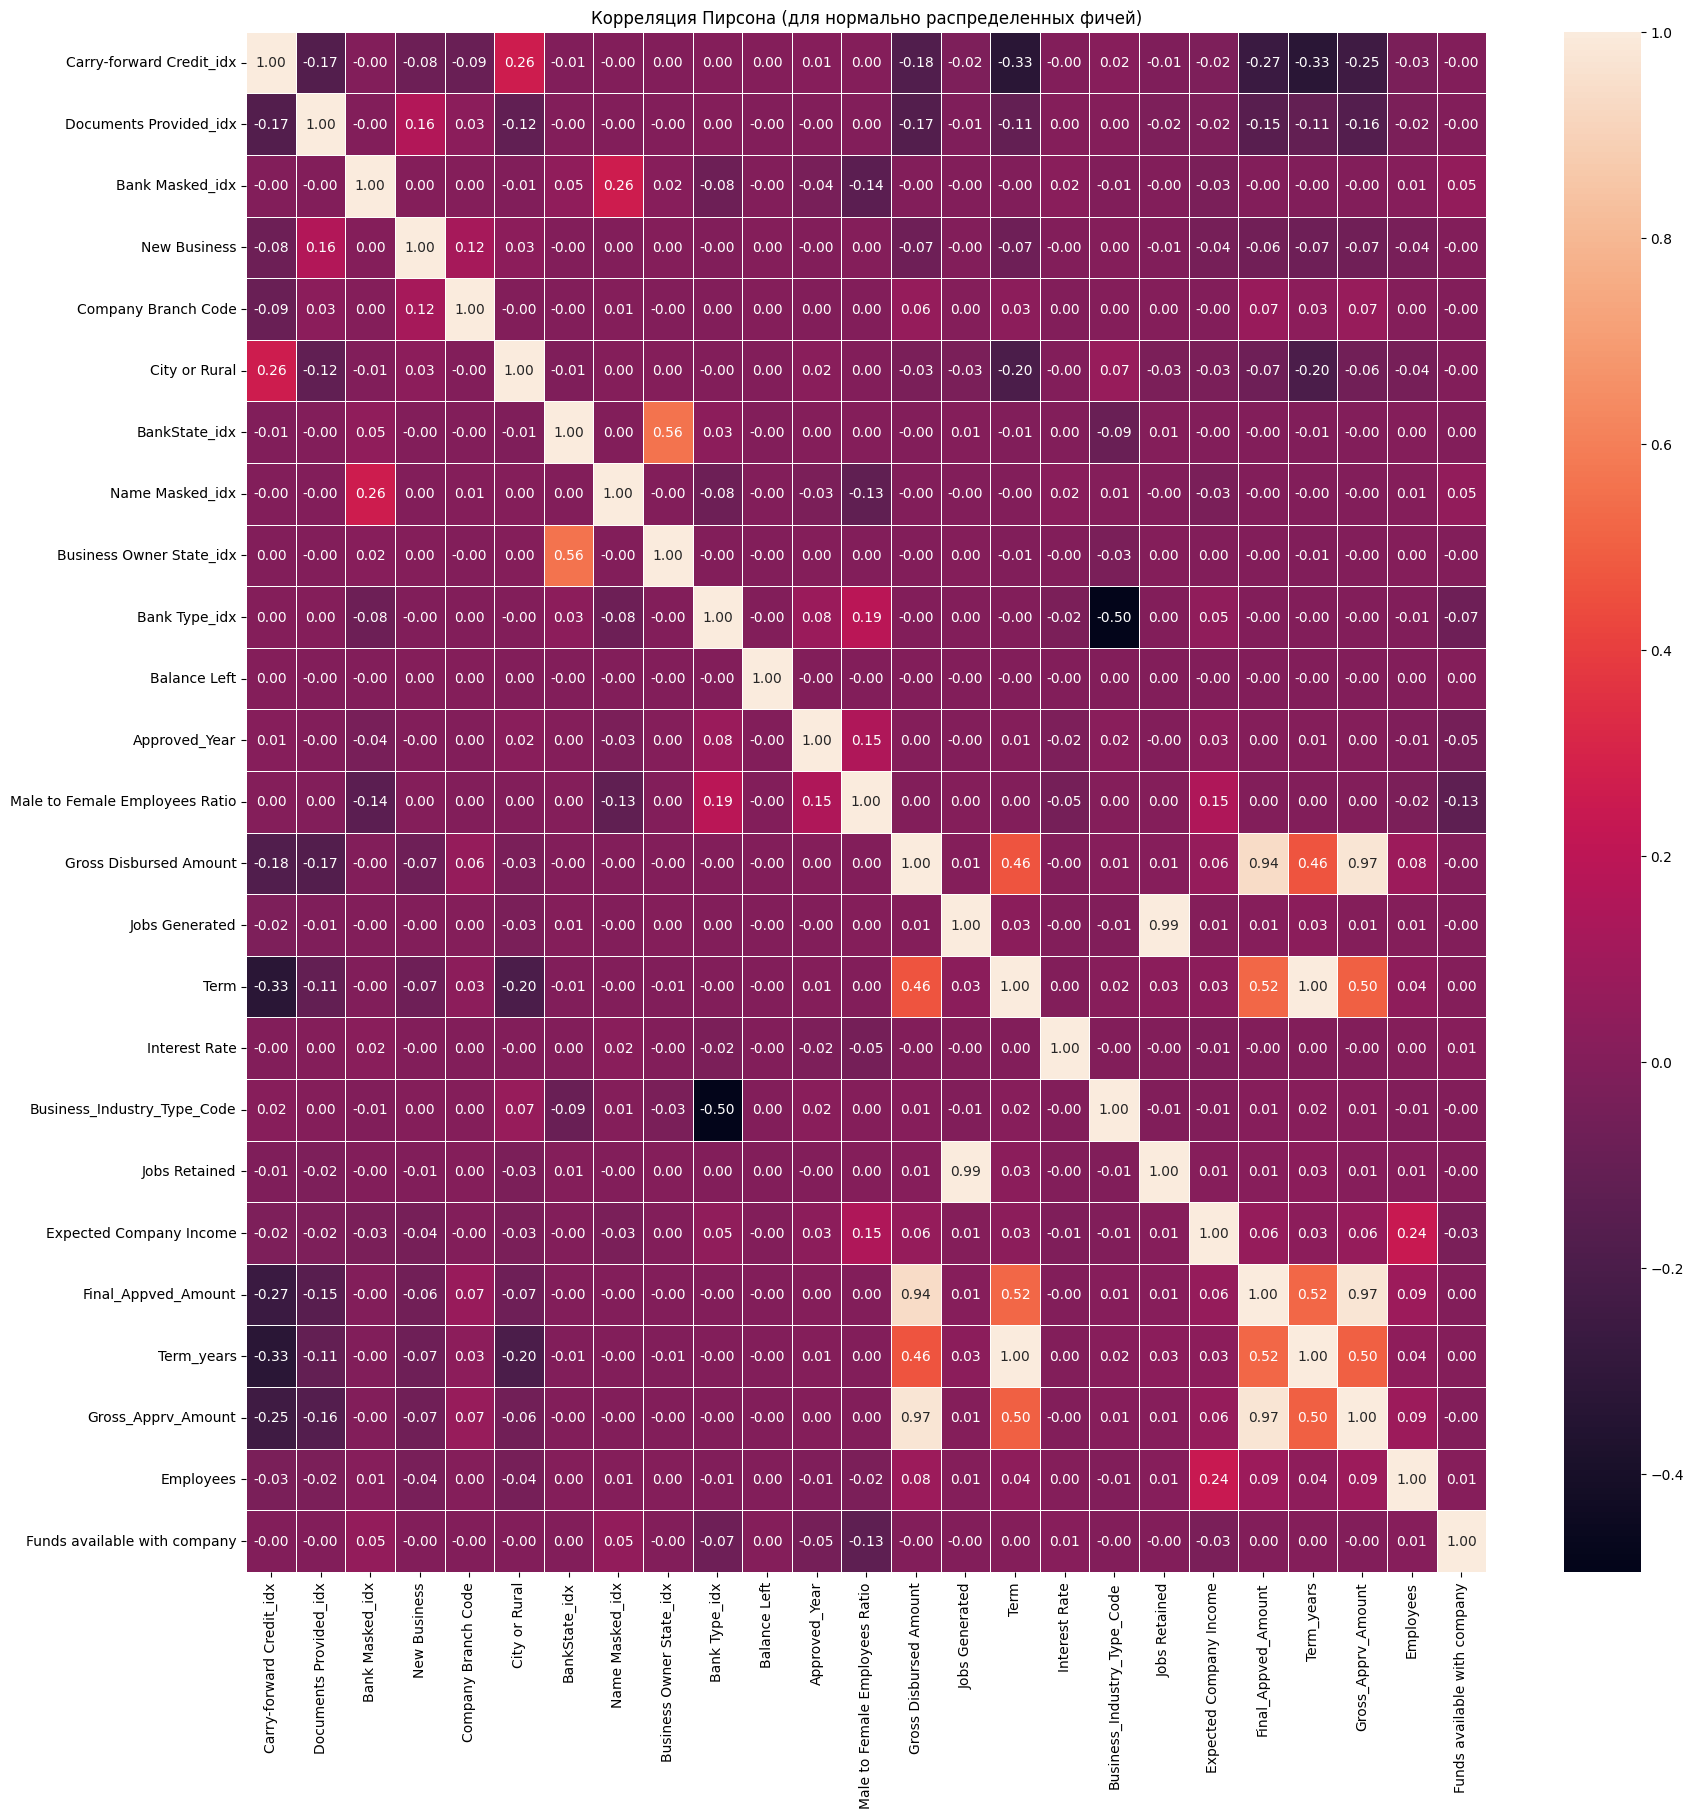

In [115]:
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(
    corr.toArray(),
    xticklabels=FEATURES,
    yticklabels=FEATURES,
    linewidths=.5,
    annot=True, 
    fmt=".2f",
    ax=ax
)

ax.set_title('Корреляция Пирсона (для нормально распределенных фичей)')
plt.show()

In [116]:
corr = Correlation.corr(data, 'features', method='spearman').collect()[0][0]
display(corr)

DenseMatrix(25, 25, [1.0, -0.1905, -0.0093, -0.0825, -0.2431, 0.3002, -0.0054, 0.0009, ..., 0.0073, 0.0008, -0.1455, -0.0009, 0.0026, -0.0016, 0.0513, 1.0], False)

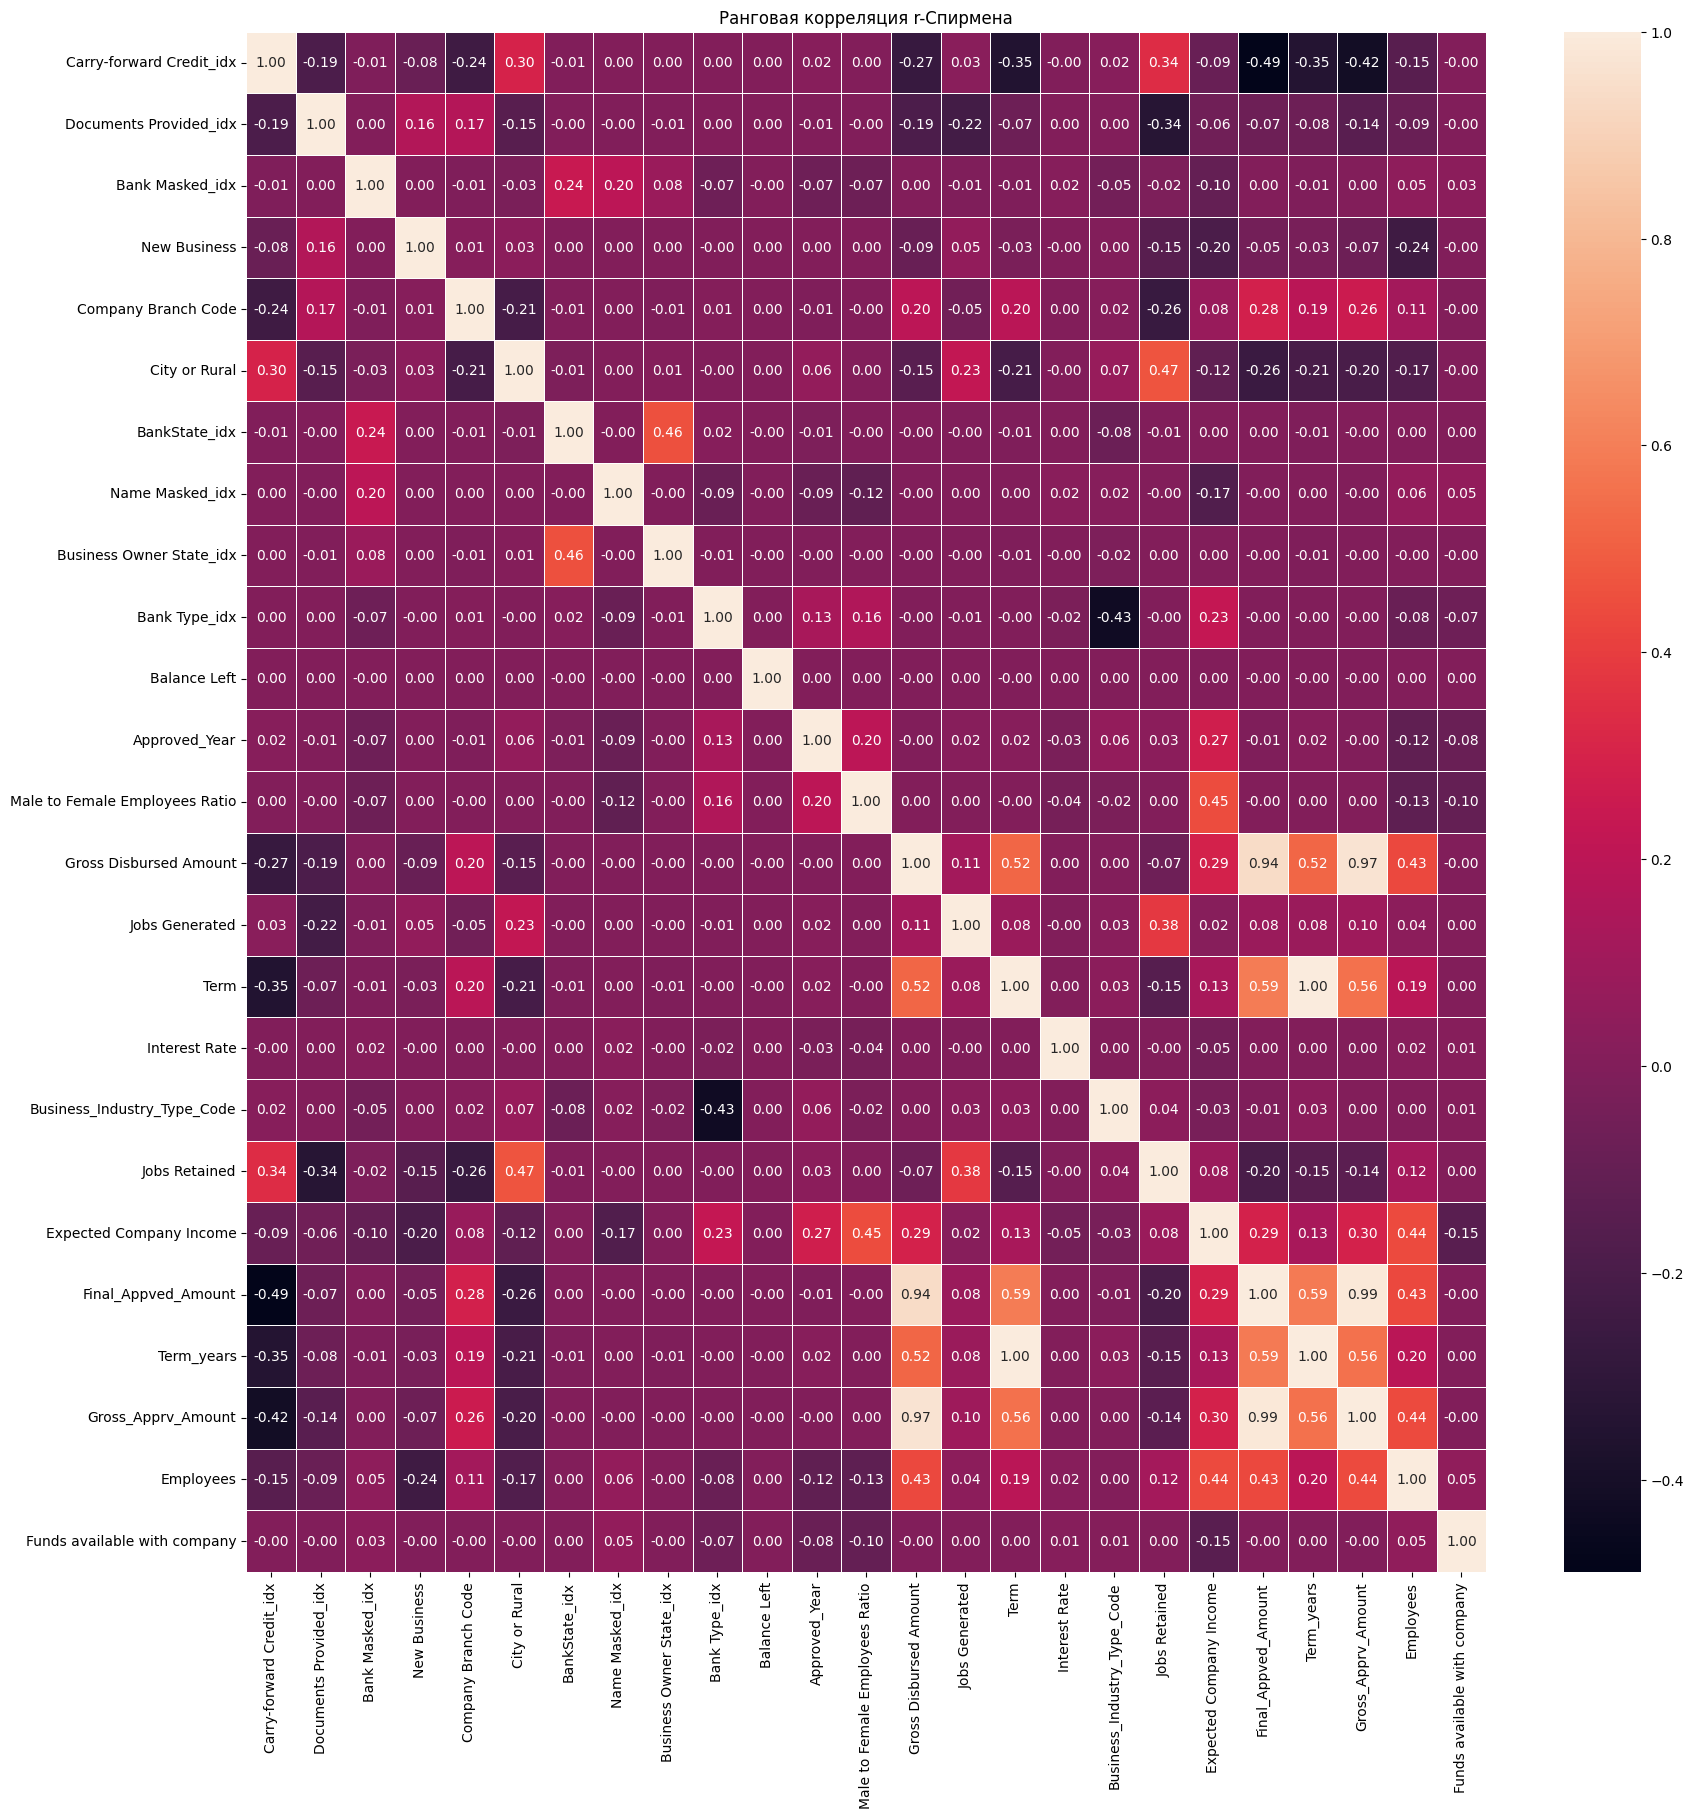

In [117]:
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(
    corr.toArray(),
    xticklabels=FEATURES,
    yticklabels=FEATURES,
    linewidths=.5,
    annot=True, 
    fmt=".2f",
    ax=ax
)

ax.set_title('Ранговая корреляция r-Спирмена')
plt.show()

Выкинем фичи с высокой корреляцией:

In [118]:
def except_values(collecton: Collection, keys: Collection) -> List:
    return [it for it in collecton if it not in keys]

In [119]:
high_corr = [
    'Term_years',
    'Gross_Apprv_Amount',
    'Gross Disbursed Amount'
]

In [120]:
FEATURES = except_values(FEATURES, high_corr)
data = VectorAssembler(inputCols = FEATURES, outputCol = 'features').transform(
    data.select(ID_COLUMN, DATE_COLUMN, TARGET_COLUMN, *FEATURES))

Обновим список оставшихся категориальных фичей:

In [121]:
CAT_FEATURES = list(set(FEATURES).intersection(CAT_FEATURES))

Вновь посмотрим на корреляцию:

In [122]:
corr = Correlation.corr(data, 'features', method='spearman').collect()[0][0]
display(corr)

DenseMatrix(22, 22, [1.0, -0.1905, -0.0093, -0.0825, -0.2431, 0.3002, -0.0054, 0.0009, ..., 0.0024, 0.0127, 0.0073, 0.0008, -0.1455, -0.0009, 0.0513, 1.0], False)

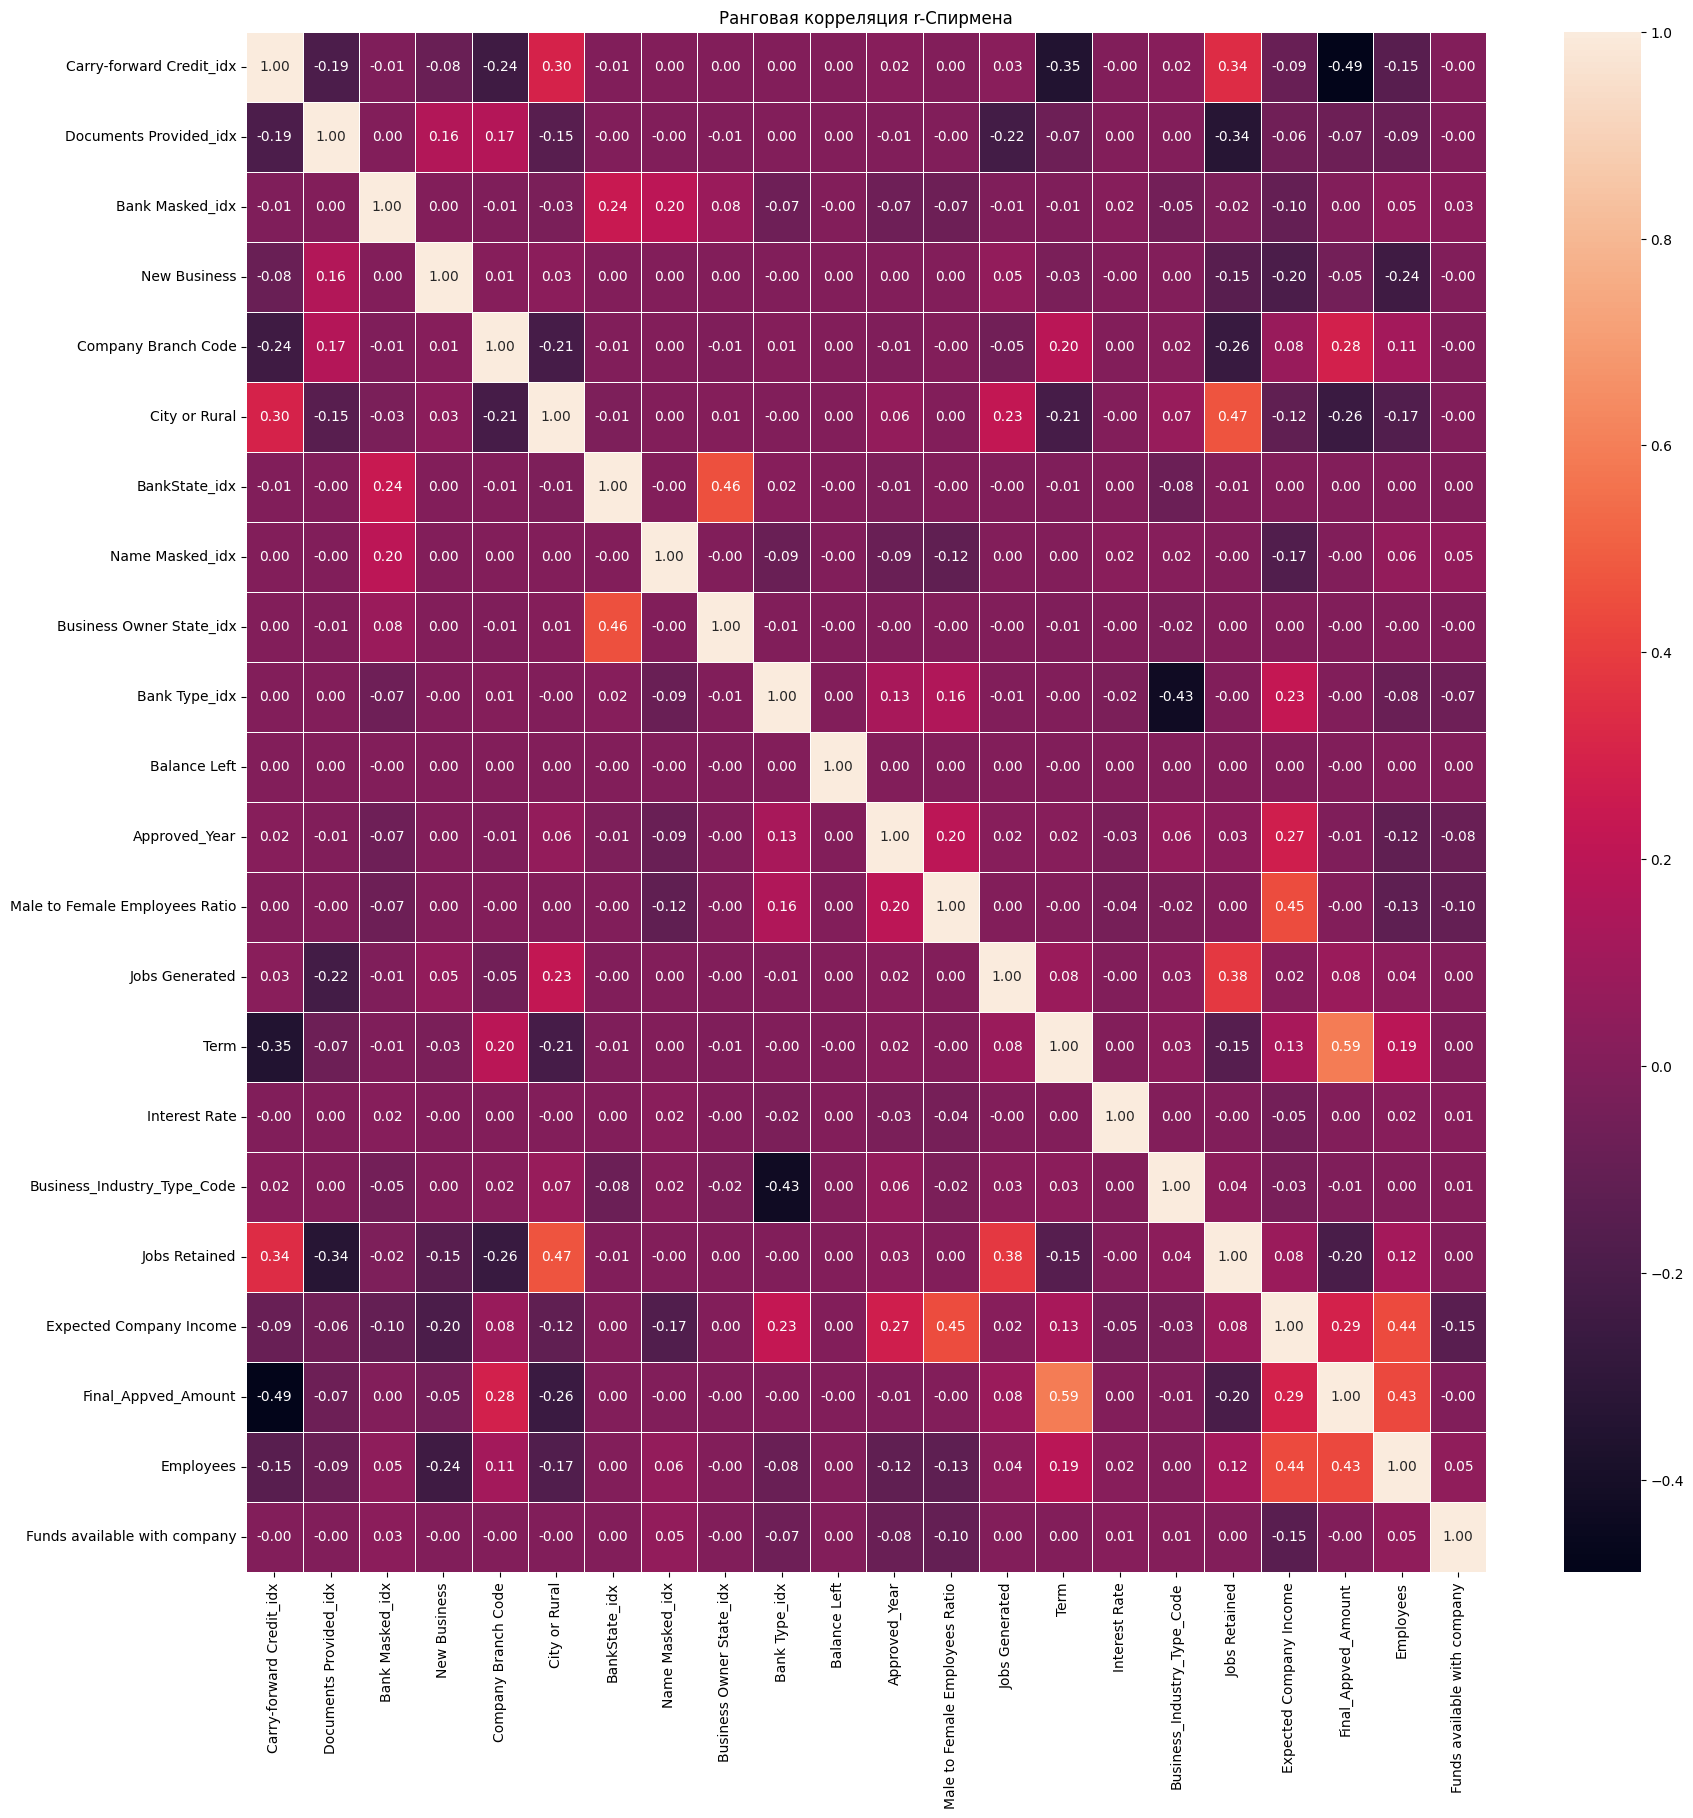

In [123]:
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(
    corr.toArray(),
    xticklabels=FEATURES,
    yticklabels=FEATURES,
    linewidths=.5,
    annot=True, 
    fmt=".2f",
    ax=ax
)

ax.set_title('Ранговая корреляция r-Спирмена')
plt.show()

### Общие статистики

In [124]:
summarizer = Summarizer.metrics("mean", "count")
display(data.select(summarizer.summary(data.features)).toPandas().style)

,"aggregate_metrics(features, 1.0)"
0,"Row(mean=DenseVector([0.2498, 0.1315, 4914.3504, 1.2793, 2812.7215, 0.7547, 1.1167, 62779.1273, 1.3781, 0.3334, 9.1842, 2008.1228, 15.3292, 9.0552, 110.7399, 7.3279, 399104.706, 11.4184, 18324941.3288, 10528977.7205, 19.123, 1253178.7775]), count=195118)"


## Создание выборок

In [125]:
train, test = data.randomSplit([0.7, 0.3], seed=7)

## Модели

### Логистическая регрессия

In [126]:
log_reg = LogisticRegression(featuresCol='features', labelCol=TARGET_COLUMN, predictionCol='prediction',
                             maxIter=100, probabilityCol='proba')

In [127]:
%%time
log_reg = log_reg.fit(data)

CPU times: total: 46.9 ms
Wall time: 1min


Коэффициенты:

In [128]:
print("Coefficients: " + str(log_reg.coefficients))
print("Intercept: " + str(log_reg.intercept))

Coefficients: [-0.12201260327765474,-0.5143163710756726,-4.6728920905638866e-07,0.01640910784336342,-1.3361300487113624e-06,0.2312237120010405,0.00012541887857574034,1.4935806891275568e-07,-0.005715030632087965,0.036183220093817935,-1.364253466547083e-06,0.00040233414088257743,-0.00024173715651079093,0.0001597129453391451,-0.01037720585233248,0.0015403719132664137,8.728889063330436e-08,2.9121724984858694e-05,9.750364282902082e-10,7.653022875094328e-09,-0.007213396605161325,7.3783672370808115e-09]
Intercept: -1.5009532396695398


Метрики:

In [129]:
def gini(model, data: pyspark.sql.DataFrame, y_true: str) -> float:
    evaluator = BinaryClassificationEvaluator(labelCol=y_true, metricName='areaUnderROC')
    auc = evaluator.evaluate(model.transform(data))
    return 2 * auc - 1

In [130]:
print("GINI (train):", gini(log_reg, train, TARGET_COLUMN)) 
print("GINI (test): ", gini(log_reg, test, TARGET_COLUMN))

GINI (train): 0.42578698212245203
GINI (test):  0.4178578918635947


In [131]:
print(f'GINI (train):    {2 * log_reg.summary.areaUnderROC - 1}')
print(f'ROC_AUC (train): {log_reg.summary.areaUnderROC}')

GINI (train):    0.4234294687046274
ROC_AUC (train): 0.7117147343523137


In [132]:
log_reg.summary.recallByLabel

[0.9992306730047535, 0.001021624382768602]

In [133]:
log_reg.params

[Param(parent='LogisticRegression_029fa5d0f2ca', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'),
 Param(parent='LogisticRegression_029fa5d0f2ca', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'),
 Param(parent='LogisticRegression_029fa5d0f2ca', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'),
 Param(parent='LogisticRegression_029fa5d0f2ca', name='featuresCol', doc='features column name.'),
 Param(parent='LogisticRegression_029fa5d0f2ca', name='fitIntercept', doc='whether to fit an intercept term.'),
 Param(parent='LogisticRegression_029fa5d0f2ca', name='labelCol', doc='label column name.'),
 Param(parent='LogisticRegression_029fa5d0f2ca', name='lowerBoundsOnCoefficients', doc='The lower bounds on coefficients if fitting under bound cons

In [134]:
log_reg.transform(data.select(TARGET_COLUMN, 'features')).show(5)

+--------------+--------------------+--------------------+--------------------+----------+
|Default_Status|            features|       rawPrediction|               proba|prediction|
+--------------+--------------------+--------------------+--------------------+----------+
|             0|[0.0,0.0,1260.0,1...|[2.90758090717099...|[0.94821991842970...|       0.0|
|             1|[1.0,0.0,564.0,1....|[1.39151222714307...|[0.80083355186392...|       0.0|
|             0|[1.0,0.0,21.0,2.0...|[1.24793502058421...|[0.77694219867570...|       0.0|
|             0|[0.0,0.0,1.0,1.0,...|[3.34386843663309...|[0.96590347508930...|       0.0|
|             0|[0.0,1.0,33.0,2.0...|[2.23504652073302...|[0.90335285069596...|       0.0|
+--------------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



### Дерево решений

In [135]:
from pyspark.ml.classification import DecisionTreeClassifier

In [136]:
decision_tree = DecisionTreeClassifier(featuresCol='features', labelCol=TARGET_COLUMN, predictionCol='prediction', maxDepth=15)

In [137]:
%%time
decision_tree = decision_tree.fit(train)

CPU times: total: 0 ns
Wall time: 32.6 s


Метрики:

In [138]:
print("GINI (train):", gini(decision_tree, train, TARGET_COLUMN)) 
print("GINI (test): ", gini(decision_tree, test, TARGET_COLUMN))

GINI (train): 0.20875305586300685
GINI (test):  0.13297552327302586


In [139]:
decision_tree.transform(data.select(TARGET_COLUMN, 'features')).show(5)

+--------------+--------------------+--------------+--------------------+----------+
|Default_Status|            features| rawPrediction|         probability|prediction|
+--------------+--------------------+--------------+--------------------+----------+
|             0|[0.0,0.0,1260.0,1...| [379.0,123.0]|[0.75498007968127...|       0.0|
|             1|[1.0,0.0,564.0,1....|    [3.0,66.0]|[0.04347826086956...|       1.0|
|             0|[1.0,0.0,21.0,2.0...| [4309.0,32.0]|[0.99262842662980...|       0.0|
|             0|[0.0,0.0,1.0,1.0,...| [2309.0,53.0]|[0.97756138865368...|       0.0|
|             0|[0.0,1.0,33.0,2.0...|[4236.0,313.0]|[0.93119366893822...|       0.0|
+--------------+--------------------+--------------+--------------------+----------+
only showing top 5 rows



### Бустинг

In [140]:
from pyspark.ml.classification import GBTClassifier

In [141]:
gbt = GBTClassifier(featuresCol='features', labelCol=TARGET_COLUMN, predictionCol='prediction')

In [142]:
%%time
gbt = gbt.fit(train)

CPU times: total: 46.9 ms
Wall time: 2min 28s


Метрики:

In [143]:
print("GINI (train):", gini(gbt, train, TARGET_COLUMN)) 
print("GINI (test): ", gini(gbt, test, TARGET_COLUMN))

GINI (train): 0.7189162387619168
GINI (test):  0.7066360538240213


In [144]:
gbt.transform(data.select(TARGET_COLUMN, 'features')).show(5)

+--------------+--------------------+--------------------+--------------------+----------+
|Default_Status|            features|       rawPrediction|         probability|prediction|
+--------------+--------------------+--------------------+--------------------+----------+
|             0|[0.0,0.0,1260.0,1...|[1.13358558787105...|[0.90612142903349...|       0.0|
|             1|[1.0,0.0,564.0,1....|[0.43102758489956...|[0.70308985929943...|       0.0|
|             0|[1.0,0.0,21.0,2.0...|[1.45360412295340...|[0.94820161811323...|       0.0|
|             0|[0.0,0.0,1.0,1.0,...|[1.30332120946316...|[0.93128785289555...|       0.0|
|             0|[0.0,1.0,33.0,2.0...|[1.25859292690928...|[0.92533786451075...|       0.0|
+--------------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



## Пайплайны

Создадим пайплайн трансформации данных:

In [145]:
bt_indexer = StringIndexer(inputCol='Bank Type', outputCol='Bank Type_idx', handleInvalid="keep")
dp_indexer = StringIndexer(inputCol='Documents Provided', outputCol='Documents Provided_idx', handleInvalid="keep")
cfc_indexer = StringIndexer(inputCol='Carry-forward Credit', outputCol='Carry-forward Credit_idx', handleInvalid="keep")
bos_indexer = StringIndexer(inputCol='Business Owner State', outputCol='Business Owner State_idx', handleInvalid="keep")
bs_indexer = StringIndexer(inputCol='BankState', outputCol='BankState_idx', handleInvalid="keep")
bm_indexer = StringIndexer(inputCol='Bank Masked', outputCol='Bank Masked_idx', handleInvalid="keep")
nm_indexer = StringIndexer(inputCol='Name Masked', outputCol='Name Masked_idx', handleInvalid="keep")

imputer = Imputer(inputCols=FEATURES, outputCols=FEATURES, strategy='mode')

vector_assembler = VectorAssembler(inputCols = FEATURES, outputCol = 'features')

In [146]:
data_pipeline = Pipeline(stages=[
    bt_indexer,
    dp_indexer,
    cfc_indexer,
    bos_indexer,
    bs_indexer,
    bm_indexer,
    nm_indexer,
    imputer,
    vector_assembler,
])

In [147]:
data_pipeline

Pipeline_71eb787474eb

Сохраним пайплайн:

In [148]:
data_pipeline.write().overwrite().save('data_pipeline')

In [149]:
del data_pipeline
gc.collect()

42344

Считаем пайплайн:

In [150]:
data_pipeline = Pipeline.load("data_pipeline")

In [151]:
data_pipeline

Pipeline_71eb787474eb

Выведем, что было до применения пайплайна:

In [152]:
data.select(ID_COLUMN, DATE_COLUMN, TARGET_COLUMN, 'features').show(5, truncate=60)

+--------------+------------------+--------------+------------------------------------------------------------+
|Application ID|Approved_Timestamp|Default_Status|                                                    features|
+--------------+------------------+--------------+------------------------------------------------------------+
|    1020200001|        12-10-2005|             0|[0.0,0.0,1260.0,1.0,25650.0,1.0,3.0,781.0,3.0,0.0,0.0,200...|
|    1020200002|        21-11-2006|             1|[1.0,0.0,564.0,1.0,0.0,1.0,3.0,66019.0,3.0,1.0,0.0,2006.0...|
|    1020200003|        28-11-2007|             0|[1.0,0.0,21.0,2.0,0.0,2.0,1.0,47330.0,3.0,0.0,0.0,2007.0,...|
|    1020200004|        18-04-2009|             0|[0.0,0.0,1.0,1.0,1.0,1.0,0.0,45282.0,9.0,1.0,0.0,2009.0,6...|
|    1020200005|        23-11-2002|             0|[0.0,1.0,33.0,2.0,1.0,2.0,1.0,57039.0,0.0,1.0,0.0,2002.0,...|
+--------------+------------------+--------------+------------------------------------------------------

Считаем данные заново и прогоним из через пайплайн:

In [153]:
data = spark.read.csv('Train_Set_90621.csv', header=True, inferSchema=True)\
                 .drop('Amount Defaulted')

In [154]:
data_pipeline = data_pipeline.fit(data)
data = data_pipeline.transform(data)

In [155]:
data.select(ID_COLUMN, DATE_COLUMN, TARGET_COLUMN, 'features').show(5, truncate=60)

+--------------+------------------+--------------+------------------------------------------------------------+
|Application ID|Approved_Timestamp|Default_Status|                                                    features|
+--------------+------------------+--------------+------------------------------------------------------------+
|    1020200001|        12-10-2005|             0|[0.0,0.0,1260.0,1.0,25650.0,1.0,3.0,781.0,3.0,0.0,0.0,200...|
|    1020200002|        21-11-2006|             1|[1.0,0.0,564.0,1.0,0.0,1.0,3.0,66019.0,3.0,1.0,0.0,2006.0...|
|    1020200003|        28-11-2007|             0|[1.0,0.0,21.0,2.0,0.0,2.0,1.0,47330.0,3.0,0.0,0.0,2007.0,...|
|    1020200004|        18-04-2009|             0|[0.0,0.0,1.0,1.0,1.0,1.0,0.0,45282.0,9.0,1.0,0.0,2009.0,6...|
|    1020200005|        23-11-2002|             0|[0.0,1.0,33.0,2.0,1.0,2.0,1.0,57039.0,0.0,1.0,0.0,2002.0,...|
+--------------+------------------+--------------+------------------------------------------------------

Создадим новый пайплайн с обучением модели:

In [156]:
model_pipeline = Pipeline(stages=data_pipeline.stages + [log_reg])

In [157]:
model_pipeline

Pipeline_bd467f3cb106

## Поиск гиперпараметров по сетке

In [158]:
data = spark.read.csv('Train_Set_90621.csv', header=True, inferSchema=True)\
                 .drop('Amount Defaulted')

In [159]:
train, test = data.randomSplit([0.7, 0.3], seed=7)

In [160]:
paramGrid = ParamGridBuilder() \
    .addGrid(log_reg.maxIter, [10, 20, 50, 100])\
    .addGrid(log_reg.regParam, [0.0, 0.2])\
    .build()

In [161]:
crossval = CrossValidator(estimator=model_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',
                                                                  labelCol=TARGET_COLUMN, metricName='areaUnderROC'),
                          numFolds=2,
                          parallelism=2)

In [162]:
%%time
cvModel = crossval.fit(train)

CPU times: total: 3.61 s
Wall time: 42.3 s


In [163]:
cvModel.avgMetrics

[0.712890283262479,
 0.7128901320175639,
 0.7128923211341927,
 0.7128901289375151,
 0.7128918501008743,
 0.7128904407068462,
 0.7128927756901743,
 0.7128886901875562]

In [164]:
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='LogisticRegression_029fa5d0f2ca', name='maxIter', doc='max number of iterations (>= 0).'): 100, Param(parent='LogisticRegression_029fa5d0f2ca', name='regParam', doc='regularization parameter (>= 0).'): 0.0}


Сделаем предикт

In [165]:
test_pred = cvModel.transform(test)

In [166]:
test_pred.select(ID_COLUMN, TARGET_COLUMN, 'proba', 'prediction').show(n=5, truncate=False)

+--------------+--------------+----------------------------------------+----------+
|Application ID|Default_Status|proba                                   |prediction|
+--------------+--------------+----------------------------------------+----------+
|1020200003    |0             |[0.7769421986757062,0.22305780132429376]|0.0       |
|1020200006    |0             |[0.829675786330782,0.17032421366921802] |0.0       |
|1020200008    |0             |[0.7800852336406285,0.21991476635937146]|0.0       |
|1020200010    |0             |[0.8853080379624415,0.11469196203755849]|0.0       |
|1020200011    |1             |[0.9770383343263672,0.02296166567363278]|0.0       |
+--------------+--------------+----------------------------------------+----------+
only showing top 5 rows



Проверим модель:

In [167]:
print("GINI (train):", gini(cvModel, train, TARGET_COLUMN)) 
print("GINI (test): ", gini(cvModel, test, TARGET_COLUMN))

GINI (train): 0.4257887026401326
GINI (test):  0.4178549753181793


Сохраним пайплайн

In [168]:
cvModel.write().overwrite().save('cv_model')

In [169]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}